# Predicting Drug-Drug Interactions using Graph Neural Networks

---



In [1]:
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

# Install torch geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install ogb

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html


In [2]:
import argparse
import time
import os, sys
import os.path as osp
from shutil import copy
import copy as cp
from tqdm import tqdm
import pdb

import numpy as np
from sklearn.metrics import roc_auc_score
import scipy.sparse as ssp
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from torch_sparse import coalesce
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader
from torch_geometric.utils import to_networkx, to_undirected

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

import warnings
from scipy.sparse import SparseEfficiencyWarning

In [3]:
dataset = PygLinkPropPredDataset('ogbl-ddi')
split_edge = dataset.get_edge_split()
data = dataset[0]

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:00<00:00, 48.88it/s]


Extracting dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 25.32it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2832.08it/s]

Saving...



Done!


In [4]:
from torch_geometric.utils import negative_sampling, convert, to_dense_adj
ddi_graph = dataset[0]
G = convert.to_networkx(ddi_graph, to_undirected=True)

In [5]:
import matplotlib.pyplot as plt
import networkx as nx


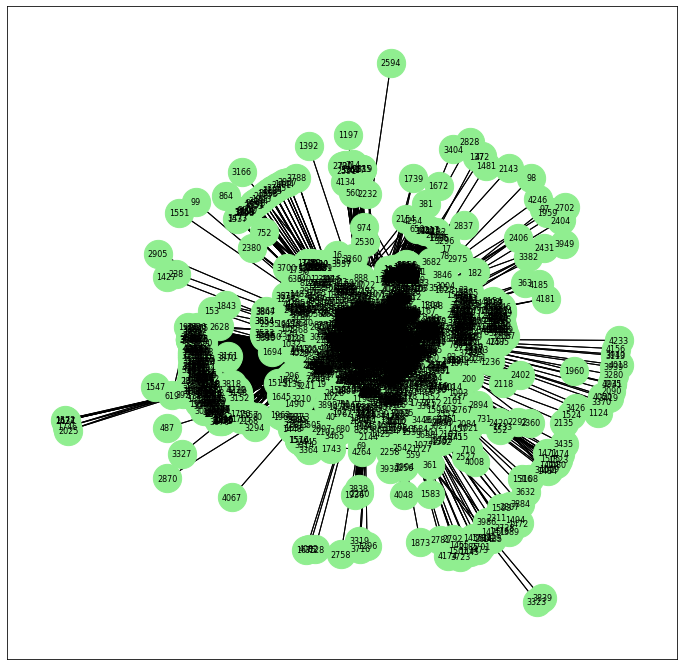

In [6]:
plt.figure(3, figsize=(12,12))
pos = nx.fruchterman_reingold_layout(G)

nx.draw_networkx(G, pos=pos, node_size = 800, font_size=8, node_color="lightgreen")
nx.draw_networkx_edges(G, pos=pos)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
plt.show()

In [7]:
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from numpy import random

In [8]:
class SpectralClustering:
    
    def __init__(self, G):
        # Initialize the graph, nodes and the normalized Laplacian

        self.graph = G
        self.normalized_laplacian = nx.linalg.normalized_laplacian_matrix(G).toarray()
        self.nodes = G.nodes()

    def compute_eigenspace(self):
        # Compute the eigenvalues and the eigenvectors using Numpy and sort them in ascending order 

        eigenvalues, eigenvectors = np.linalg.eig(self.normalized_laplacian)

        sort_index = np.argsort(eigenvalues) # Returns the list of indices that would sort the array
        sorted_eigenvectors = eigenvectors[:, sort_index]

        return sorted_eigenvectors

    def fit(self, k):
        """
        Step 1: Extract the k eigen vectors and stack them vertically to form a matrix (i.e each vector is a column)
        Step 2: Every row of this matrix represents the features of the respective nodes of the graph
        Step 3: Perform K-Means clustering on this dataset to identify k clusters

        """
        eigenvectors = self.compute_eigenspace()
        k_eigenvectors = np.array(eigenvectors)[:,:k]
        dataset = pd.DataFrame(k_eigenvectors, index=self.nodes)

        # print(dataset)

        k_means_clusters = KMeans(n_clusters = k, random_state=42)
        self.clusters = k_means_clusters.fit(k_eigenvectors)
        
    def predict_labels(self):
        # Returns the labels 
        return self.clusters.labels_

    def assign_labels(self, labels):
        # Helper to assign the labels as node attributes
        for i,node in enumerate(self.graph.nodes()):
            self.graph.nodes[node]['label'] = labels[i]
            

    def plot_graph(self, n_clusters, title='Graph after Spectral Clustering'):
        # Plots the graph 

        labels = self.clusters.labels_
        self.assign_labels(labels)

        colour_list = ['blue','lightgreen','red','yellow','cyan', 'magenta','lightblue','grey','black','pink','orange','green','purple','maroon']
        sampled_colours = dict(zip(set(labels),random.sample(colour_list, n_clusters)))

        legend_handles = []
        for label, color in sampled_colours.items():
            colour_handle = mpatches.Patch(color=color, label=label)
            legend_handles.append(colour_handle)

        colours = [sampled_colours[i] for i in labels]

        pos_fr = nx.fruchterman_reingold_layout(self.graph)
        plt.figure(figsize=(8,8))
        plt.title(title)
        plt.legend(handles=legend_handles)
        nx.draw(self.graph, pos=pos_fr, node_size=500, node_color=colours, with_labels=True)
        plt.show()

In [9]:

import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from torch_geometric.utils import convert

In [10]:
G = convert.to_networkx(data,to_undirected = True)


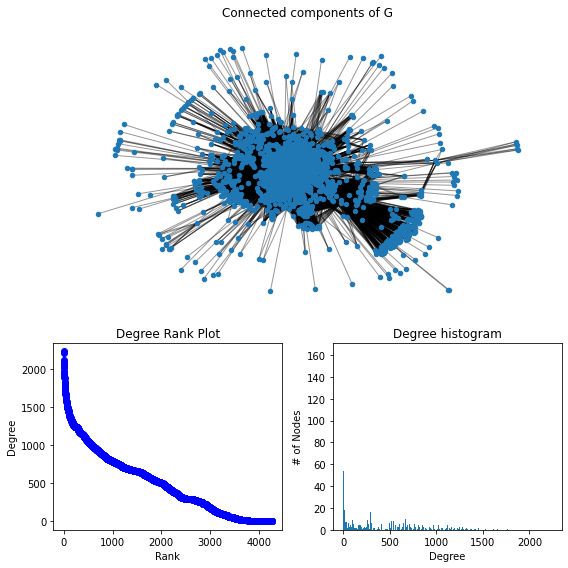

In [12]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()